In [1]:
# Install dependencies (run this in a notebook cell, not needed in code below)
!pip install transformers datasets seqeval torch
!pip install datasets
!pip install seqeval --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00

In [3]:
import torch
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import defaultdict, Counter
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import precision_score as sk_precision, recall_score as sk_recall, f1_score as sk_f1

# Sets device
device = 0 if torch.cuda.is_available() else -1
print(f"Device set to use {'cuda:0' if device == 0 else 'cpu'}")

# Loads dataset
dataset = load_dataset("dell-research-harvard/newswire")
full_data = dataset["train"]

# Selects 10000 random rows from the dataset
# Maintaining seed set by teammate
random.seed(42)
indices = random.sample(range(len(full_data)), 10000)
small_corpus = full_data.select(indices)

# Shuffle and split
random.seed(42)
indices = list(range(len(small_corpus)))
random.shuffle(indices)
split_idx = int(0.8 * len(indices))
train_data = small_corpus.select(indices[:split_idx])
test_data = small_corpus.select(indices[split_idx:])

label_names = [
    "O", "B-PER", "I-PER", "B-ORG", "I-ORG",
    "B-LOC", "I-LOC", "B-MISC", "I-MISC"
]

# Model dictionary
models_to_compare = {
    "Custom Historical NER": "dell-research-harvard/historical_newspaper_ner",
    "RoBERTa-Large (ConLL03)": "Jean-Baptiste/roberta-large-ner-english",
    "BERT-Large (ConLL03)": "dbmdz/bert-large-cased-finetuned-conll03-english",
    "DistilBERT (ConLL03)": "elastic/distilbert-base-uncased-finetuned-conll03-english"}

# Custom palette created to match the colours from within the original paper images
custom_palette = [
    "#F4A300",
    "#4BE3AC",
    "#9B5DE5",
    "#033268",
    "#E777C2",
    "#6BA3D1",
    "#CFA15A",
    "#C0D2C1",
    "#E2B97C",
    "#EDE9E0",
    "#FF7F50",
    "#1B998B",
    "#8A5082",
    "#3A86FF",
    "#BDBF09",
]

## Consolidating code
#
# Defines prediction function
def get_predictions(model_name, test_data):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    pipe = TokenClassificationPipeline(model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)

    true_labels, pred_labels = [], []

    for row in test_data:
        words = row["ner_words"]
        gold = row["ner_labels"]
        sentence = " ".join(words)
        prediction = pipe(sentence)

        # Initialize with o
        pred_seq = ["O"] * len(words)
        for ent in prediction:
            entity = ent.get("entity_group", ent.get("entity"))
            word = ent["word"]

            # Match predicted word to a token
            for idx, w in enumerate(words):
                if word.lower() in w.lower() and pred_seq[idx] == "O":
                    pred_seq[idx] = "B-" + entity
                    break

        gold_seq = gold
        true_labels.append(gold_seq)
        pred_labels.append(pred_seq)

    return true_labels, pred_labels

# Flatten labels
def flatten_labels(true_labels, pred_labels):
    return (
        [label for seq in true_labels for label in seq],
        [label for seq in pred_labels for label in seq]
    )

# Evaluation
def evaluate_model(name, true_labels, pred_labels):
    print(f"\n=== {name} ===")
    flat_true, flat_pred = flatten_labels(true_labels, pred_labels)
    print(f"Precision: {sk_precision(flat_true, flat_pred, average='macro', zero_division=1)}")
    print(f"Recall: {sk_recall(flat_true, flat_pred, average='macro', zero_division=1)}")
    print(f"F1 Score: {sk_f1(flat_true, flat_pred, average='macro', zero_division=1)}")
    print("\nDetailed Report:\n", classification_report(true_labels, pred_labels, zero_division=1))

results = {}
detailed_results = {}

for name, model_path in models_to_compare.items():
    print(f"Evaluating {name}...")
    true, pred = get_predictions(model_path, test_data)
    evaluate_model(name, true, pred)
    flat_true, flat_pred = flatten_labels(true, pred)
    results[name] = {
        "Precision": sk_precision(flat_true, flat_pred, average="macro", zero_division=1),
        "Recall": sk_recall(flat_true, flat_pred, average="macro", zero_division=1),
        "F1 Score": sk_f1(flat_true, flat_pred, average="macro", zero_division=1)
    }
    detailed_results[name] = classification_report(true, pred, output_dict=True)

results_df = pd.DataFrame(results).T.sort_values("F1 Score", ascending=False)
print(results_df)

Device set to use cuda:0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

1878_data_clean.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

1879_data_clean.json:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

1881_data_clean.json:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

1890_data_clean.json:   0%|          | 0.00/95.3M [00:00<?, ?B/s]

1884_data_clean.json:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

1883_data_clean.json:   0%|          | 0.00/36.9M [00:00<?, ?B/s]

1888_data_clean.json:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

1891_data_clean.json:   0%|          | 0.00/108M [00:00<?, ?B/s]

1889_data_clean.json:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

1886_data_clean.json:   0%|          | 0.00/52.4M [00:00<?, ?B/s]

1892_data_clean.json:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

1893_data_clean.json:   0%|          | 0.00/103M [00:00<?, ?B/s]

1880_data_clean.json:   0%|          | 0.00/26.8M [00:00<?, ?B/s]

1882_data_clean.json:   0%|          | 0.00/29.3M [00:00<?, ?B/s]

1887_data_clean.json:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

1885_data_clean.json:   0%|          | 0.00/53.1M [00:00<?, ?B/s]

1894_data_clean.json:   0%|          | 0.00/113M [00:00<?, ?B/s]

1895_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1896_data_clean.json:   0%|          | 0.00/126M [00:00<?, ?B/s]

1897_data_clean.json:   0%|          | 0.00/139M [00:00<?, ?B/s]

1898_data_clean.json:   0%|          | 0.00/147M [00:00<?, ?B/s]

1899_data_clean.json:   0%|          | 0.00/135M [00:00<?, ?B/s]

1900_data_clean.json:   0%|          | 0.00/123M [00:00<?, ?B/s]

1901_data_clean.json:   0%|          | 0.00/111M [00:00<?, ?B/s]

1902_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1903_data_clean.json:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

1904_data_clean.json:   0%|          | 0.00/106M [00:00<?, ?B/s]

1905_data_clean.json:   0%|          | 0.00/105M [00:00<?, ?B/s]

1906_data_clean.json:   0%|          | 0.00/116M [00:00<?, ?B/s]

1907_data_clean.json:   0%|          | 0.00/98.2M [00:00<?, ?B/s]

1909_data_clean.json:   0%|          | 0.00/114M [00:00<?, ?B/s]

1908_data_clean.json:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

1910_data_clean.json:   0%|          | 0.00/127M [00:00<?, ?B/s]

1911_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1912_data_clean.json:   0%|          | 0.00/121M [00:00<?, ?B/s]

1913_data_clean.json:   0%|          | 0.00/125M [00:00<?, ?B/s]

1914_data_clean.json:   0%|          | 0.00/121M [00:00<?, ?B/s]

1916_data_clean.json:   0%|          | 0.00/126M [00:00<?, ?B/s]

1915_data_clean.json:   0%|          | 0.00/120M [00:00<?, ?B/s]

1917_data_clean.json:   0%|          | 0.00/166M [00:00<?, ?B/s]

1918_data_clean.json:   0%|          | 0.00/171M [00:00<?, ?B/s]

1919_data_clean.json:   0%|          | 0.00/171M [00:00<?, ?B/s]

1920_data_clean.json:   0%|          | 0.00/368M [00:00<?, ?B/s]

1921_data_clean.json:   0%|          | 0.00/380M [00:00<?, ?B/s]

1922_data_clean.json:   0%|          | 0.00/375M [00:00<?, ?B/s]

1923_data_clean.json:   0%|          | 0.00/381M [00:00<?, ?B/s]

1924_data_clean.json:   0%|          | 0.00/383M [00:00<?, ?B/s]

1925_data_clean.json:   0%|          | 0.00/383M [00:00<?, ?B/s]

1926_data_clean.json:   0%|          | 0.00/379M [00:00<?, ?B/s]

1927_data_clean.json:   0%|          | 0.00/390M [00:00<?, ?B/s]

1928_data_clean.json:   0%|          | 0.00/435M [00:00<?, ?B/s]

1930_data_clean.json:   0%|          | 0.00/454M [00:00<?, ?B/s]

1929_data_clean.json:   0%|          | 0.00/460M [00:00<?, ?B/s]

1931_data_clean.json:   0%|          | 0.00/442M [00:00<?, ?B/s]

1932_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1933_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1934_data_clean.json:   0%|          | 0.00/472M [00:00<?, ?B/s]

1935_data_clean.json:   0%|          | 0.00/461M [00:00<?, ?B/s]

1936_data_clean.json:   0%|          | 0.00/445M [00:00<?, ?B/s]

1940_data_clean.json:   0%|          | 0.00/426M [00:00<?, ?B/s]

1941_data_clean.json:   0%|          | 0.00/435M [00:00<?, ?B/s]

1937_data_clean.json:   0%|          | 0.00/450M [00:00<?, ?B/s]

1939_data_clean.json:   0%|          | 0.00/454M [00:00<?, ?B/s]

1938_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1942_data_clean.json:   0%|          | 0.00/463M [00:00<?, ?B/s]

1943_data_clean.json:   0%|          | 0.00/501M [00:00<?, ?B/s]

1944_data_clean.json:   0%|          | 0.00/516M [00:00<?, ?B/s]

1945_data_clean.json:   0%|          | 0.00/499M [00:00<?, ?B/s]

1946_data_clean.json:   0%|          | 0.00/550M [00:00<?, ?B/s]

1947_data_clean.json:   0%|          | 0.00/540M [00:00<?, ?B/s]

1949_data_clean.json:   0%|          | 0.00/507M [00:00<?, ?B/s]

1948_data_clean.json:   0%|          | 0.00/504M [00:00<?, ?B/s]

1950_data_clean.json:   0%|          | 0.00/517M [00:00<?, ?B/s]

1951_data_clean.json:   0%|          | 0.00/537M [00:00<?, ?B/s]

1952_data_clean.json:   0%|          | 0.00/609M [00:00<?, ?B/s]

1953_data_clean.json:   0%|          | 0.00/630M [00:00<?, ?B/s]

1954_data_clean.json:   0%|          | 0.00/609M [00:00<?, ?B/s]

1955_data_clean.json:   0%|          | 0.00/604M [00:00<?, ?B/s]

1956_data_clean.json:   0%|          | 0.00/605M [00:00<?, ?B/s]

1957_data_clean.json:   0%|          | 0.00/622M [00:00<?, ?B/s]

1958_data_clean.json:   0%|          | 0.00/597M [00:00<?, ?B/s]

1959_data_clean.json:   0%|          | 0.00/604M [00:00<?, ?B/s]

1960_data_clean.json:   0%|          | 0.00/582M [00:00<?, ?B/s]

1961_data_clean.json:   0%|          | 0.00/561M [00:00<?, ?B/s]

1962_data_clean.json:   0%|          | 0.00/550M [00:00<?, ?B/s]

1963_data_clean.json:   0%|          | 0.00/557M [00:00<?, ?B/s]

1964_data_clean.json:   0%|          | 0.00/560M [00:00<?, ?B/s]

1965_data_clean.json:   0%|          | 0.00/510M [00:00<?, ?B/s]

1966_data_clean.json:   0%|          | 0.00/506M [00:00<?, ?B/s]

1967_data_clean.json:   0%|          | 0.00/502M [00:00<?, ?B/s]

1968_data_clean.json:   0%|          | 0.00/471M [00:00<?, ?B/s]

1970_data_clean.json:   0%|          | 0.00/473M [00:00<?, ?B/s]

1969_data_clean.json:   0%|          | 0.00/482M [00:00<?, ?B/s]

1971_data_clean.json:   0%|          | 0.00/463M [00:00<?, ?B/s]

1972_data_clean.json:   0%|          | 0.00/441M [00:00<?, ?B/s]

1973_data_clean.json:   0%|          | 0.00/419M [00:00<?, ?B/s]

1974_data_clean.json:   0%|          | 0.00/421M [00:00<?, ?B/s]

1975_data_clean.json:   0%|          | 0.00/423M [00:00<?, ?B/s]

1976_data_clean.json:   0%|          | 0.00/390M [00:00<?, ?B/s]

1977_data_clean.json:   0%|          | 0.00/364M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/23 [00:00<?, ?it/s]

Evaluating Custom Historical NER...


tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



=== Custom Historical NER ===
Precision: 0.7912509035169812
Recall: 0.1278774027868087
F1 Score: 0.13334184096610818

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.91      0.12      0.20     11169
        MISC       0.36      0.01      0.02      7775
         ORG       0.61      0.02      0.04      4662
         PER       0.35      0.00      0.00      9748

   micro avg       0.81      0.04      0.08     33354
   macro avg       0.55      0.04      0.07     33354
weighted avg       0.57      0.04      0.08     33354

Evaluating RoBERTa-Large (ConLL03)...


tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Device set to use cuda:0



=== RoBERTa-Large (ConLL03) ===
Precision: 0.6224652231742801
Recall: 0.11180629816820126
F1 Score: 0.10423326687691704

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.35      0.00      0.00     11169
        MISC       0.21      0.00      0.00      7775
         ORG       0.03      0.00      0.00      4662
         PER       0.12      0.00      0.00      9748

   micro avg       0.15      0.00      0.00     33354
   macro avg       0.18      0.00      0.00     33354
weighted avg       0.21      0.00      0.00     33354

Evaluating BERT-Large (ConLL03)...


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



=== BERT-Large (ConLL03) ===
Precision: 0.8265771895558732
Recall: 0.25944669200297266
F1 Score: 0.299513138619562

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.75      0.39      0.51     11169
        MISC       0.77      0.38      0.51      7775
         ORG       0.22      0.14      0.17      4662
         PER       0.63      0.31      0.41      9748

   micro avg       0.63      0.33      0.43     33354
   macro avg       0.59      0.30      0.40     33354
weighted avg       0.64      0.33      0.43     33354

Evaluating DistilBERT (ConLL03)...


tokenizer_config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

Device set to use cuda:0



=== DistilBERT (ConLL03) ===
Precision: 0.8097783843557639
Recall: 0.26950134876978016
F1 Score: 0.3013832380006564

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.71      0.45      0.55     11169
        MISC       0.77      0.33      0.47      7775
         ORG       0.19      0.17      0.18      4662
         PER       0.47      0.28      0.35      9748

   micro avg       0.54      0.33      0.41     33354
   macro avg       0.53      0.31      0.39     33354
weighted avg       0.58      0.33      0.42     33354

                         Precision    Recall  F1 Score
DistilBERT (ConLL03)      0.809778  0.269501  0.301383
BERT-Large (ConLL03)      0.826577  0.259447  0.299513
Custom Historical NER     0.791251  0.127877  0.133342
RoBERTa-Large (ConLL03)   0.622465  0.111806  0.104233


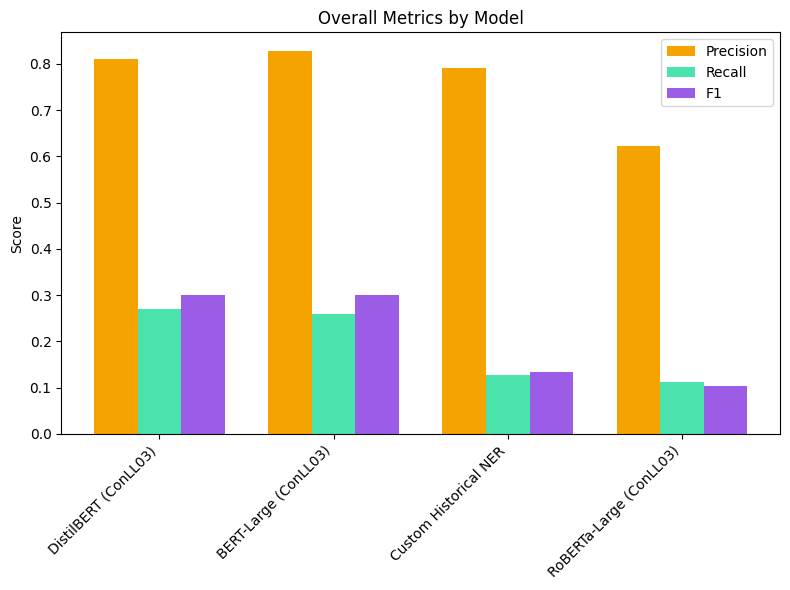

In [4]:
# Plots global scores
def plot_global_results(df):
    x = range(len(df))
    width = 0.25
    colors = custom_palette[:3]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar([i - width for i in x], df["Precision"], width=width, label="Precision", color=colors[0])
    ax.bar(x, df["Recall"], width=width, label="Recall", color=colors[1])
    ax.bar([i + width for i in x], df["F1 Score"], width=width, label="F1", color=colors[2])
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=45, ha="right")
    ax.set_ylabel("Score")
    ax.set_title("Overall Metrics by Model")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_global_results(results_df)

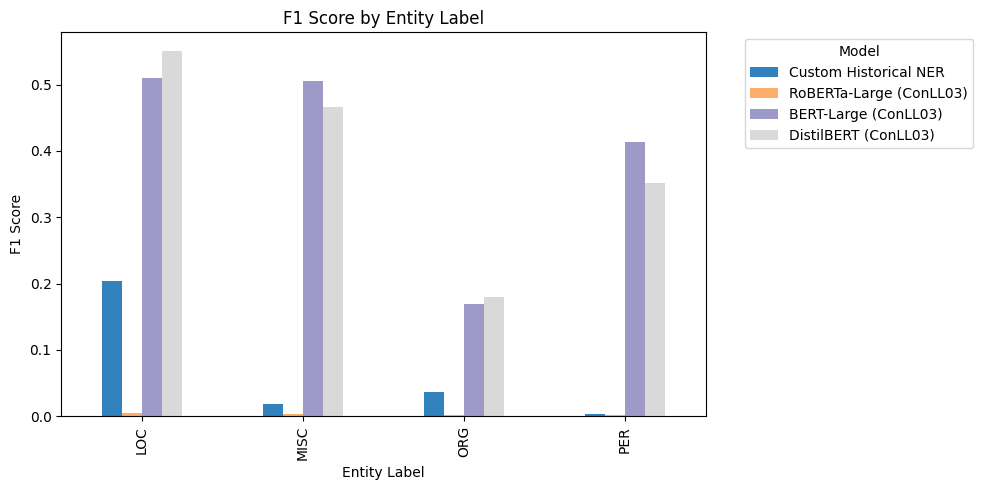

In [5]:
# Plot per-label F1
def plot_label_scores(detail_results):
    labels = sorted({label for r in detail_results.values() for label in r if "avg" not in label and label != "accuracy"})
    data = {model: {label: detail_results[model].get(label, {}).get("f1-score", 0) for label in labels} for model in detail_results}
    df = pd.DataFrame(data)
    df.plot(kind="bar", figsize=(10, 5), colormap='tab20c')
    plt.title("F1 Score by Entity Label")
    plt.ylabel("F1 Score")
    plt.xlabel("Entity Label")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_label_scores(detailed_results)

<ipython-input-6-e4c64bc030ba>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=topic_counts.index, x=topic_counts.values, palette=custom_palette[:len(topic_counts)])
<ipython-input-6-e4c64bc030ba>:5: UserWarning: 
The palette list has fewer values (15) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(y=topic_counts.index, x=topic_counts.values, palette=custom_palette[:len(topic_counts)])


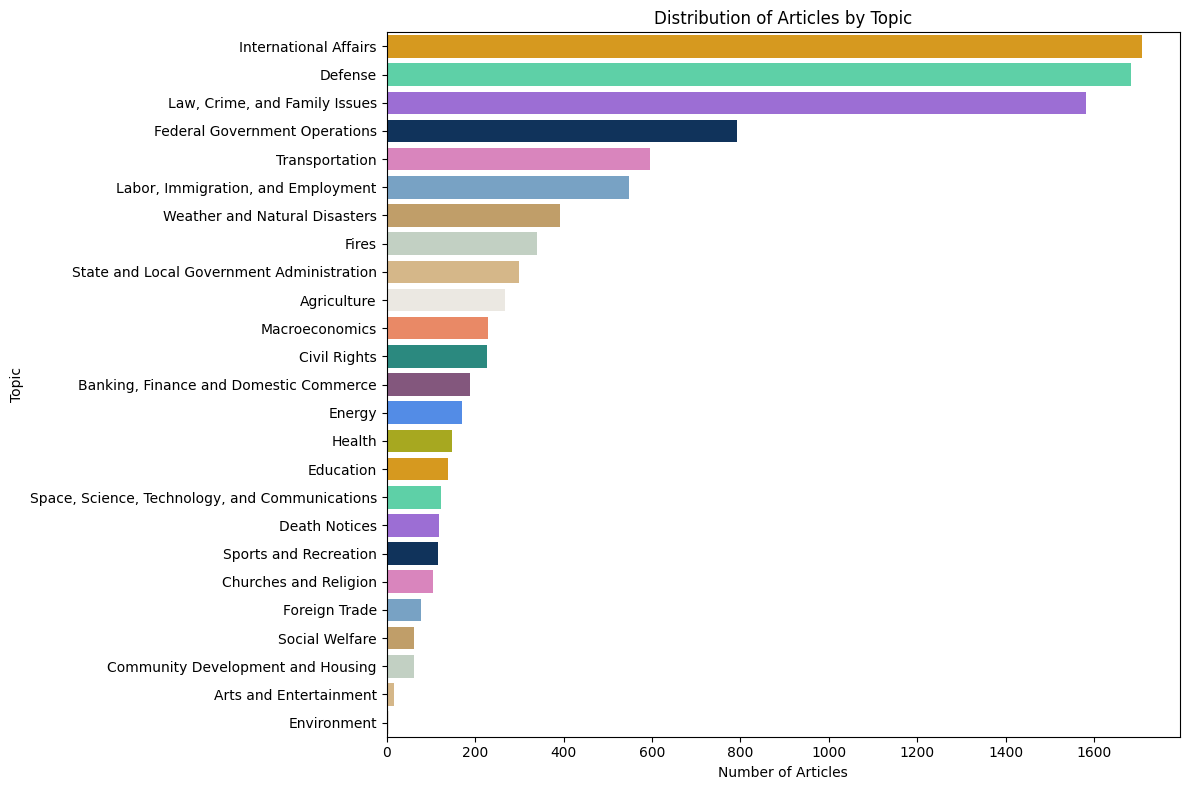

In [6]:
# Topic distribution plot
def plot_topic_distribution(df):
    topic_counts = df['ca_topic'].value_counts()
    plt.figure(figsize=(12, 8))
    sns.barplot(y=topic_counts.index, x=topic_counts.values, palette=custom_palette[:len(topic_counts)])
    plt.title('Distribution of Articles by Topic')
    plt.xlabel('Number of Articles')
    plt.ylabel('Topic')
    plt.tight_layout()
    plt.show()

plot_topic_distribution(pd.DataFrame(small_corpus))

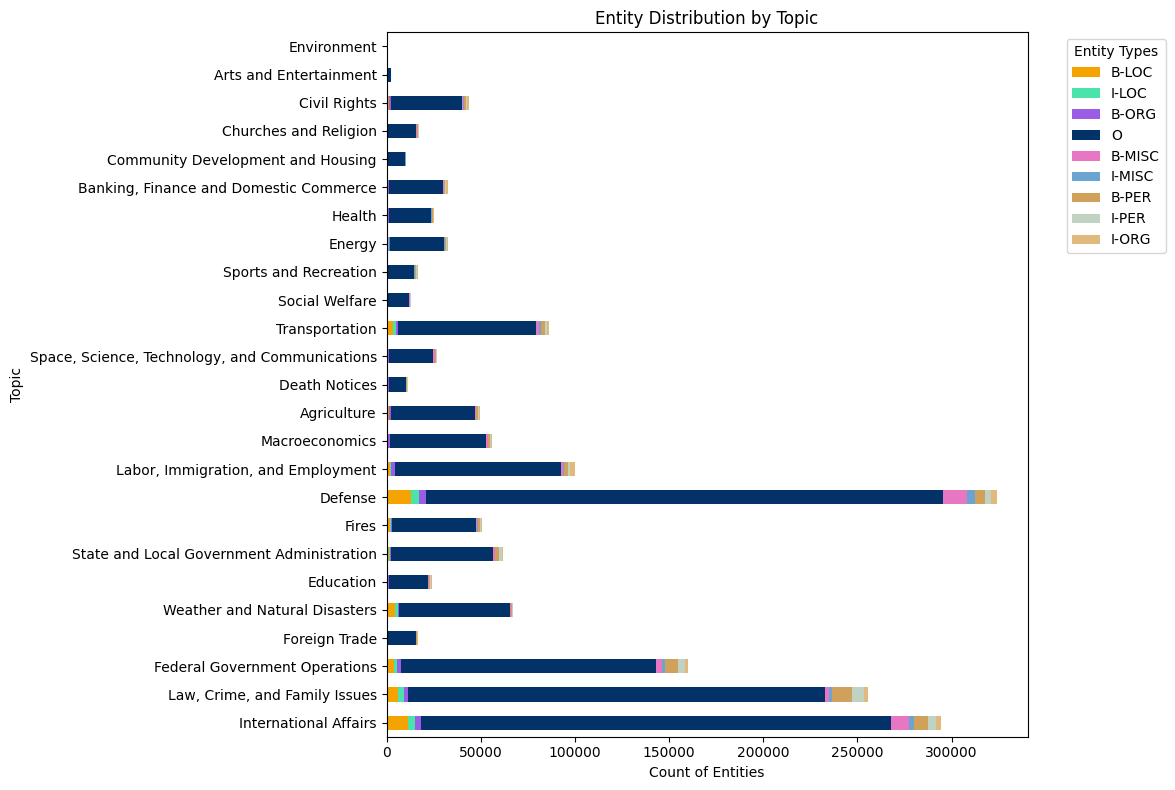

In [7]:
# Entity distribution by topic
def plot_entity_distribution_by_topic(df):
    entity_counts_by_topic = defaultdict(Counter)
    for _, row in df.iterrows():
        entity_counts_by_topic[row['ca_topic']].update(row['ner_labels'])

    entity_counts_df = pd.DataFrame(entity_counts_by_topic).T.fillna(0).astype(int)
    entity_counts_df.plot(kind='barh', stacked=True, figsize=(12, 8), color=custom_palette[:len(entity_counts_df.columns)])
    plt.title('Entity Distribution by Topic')
    plt.xlabel('Count of Entities')
    plt.ylabel('Topic')
    plt.legend(title='Entity Types', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_entity_distribution_by_topic(pd.DataFrame(small_corpus))

<ipython-input-8-f47705f222f5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette=custom_palette[:len(label_counts)])


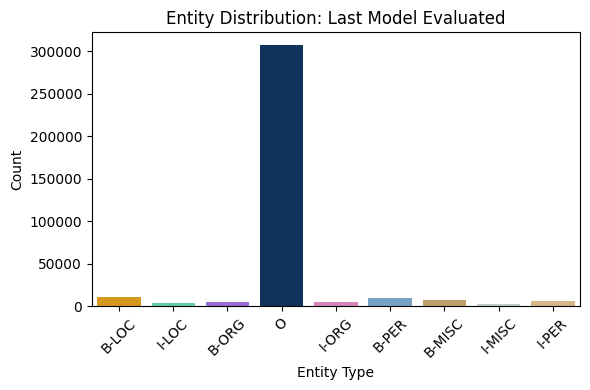

In [8]:
# Entity type distribution
def plot_entity_distribution(true_labels, title="Entity Type Distribution"):
    flat_labels = [label for seq in true_labels for label in seq]
    label_counts = Counter(flat_labels)
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette=custom_palette[:len(label_counts)])
    plt.title(title)
    plt.xlabel("Entity Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_entity_distribution(true, title="Entity Distribution: Last Model Evaluated")

In [9]:
# Topic-wise metrics
def topic_metrics_by_model():
    topic_metrics = defaultdict(lambda: defaultdict(dict))
    for model_name, model_path in models_to_compare.items():
        true, pred = get_predictions(model_path, test_data)
        topics = [row["ca_topic"] for row in test_data]
        for topic in set(topics):
            subset = [(t, p) for t, p, tp in zip(true, pred, topics) if tp == topic]
            if not subset:
                continue
            flat_true = [label for seq, _ in subset for label in seq]
            flat_pred = [label for _, seq in subset for label in seq]
            topic_metrics[model_name][topic] = {
                "Precision": sk_precision(flat_true, flat_pred, average="macro", zero_division=1),
                "Recall": sk_recall(flat_true, flat_pred, average="macro", zero_division=1),
                "F1 Score": sk_f1(flat_true, flat_pred, average="macro", zero_division=1)
            }
    return topic_metrics

# Plotting topic-wise metrics
topic_metrics = topic_metrics_by_model()

df_topic = pd.concat({
    model: pd.DataFrame.from_dict(metrics, orient="index")
    for model, metrics in topic_metrics.items()
}).reset_index()

df_topic.columns = ["Model", "Topic", "Precision", "Recall", "F1 Score"]
plot_df = df_topic.melt(id_vars=["Model", "Topic"], var_name="Metric", value_name="Score")

Device set to use cuda:0
Device set to use cuda:0
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0


<ipython-input-10-744ddfcebb59>:26: UserWarning: The palette list has more values (15) than needed (4), which may not be intended.
  g = sns.catplot(


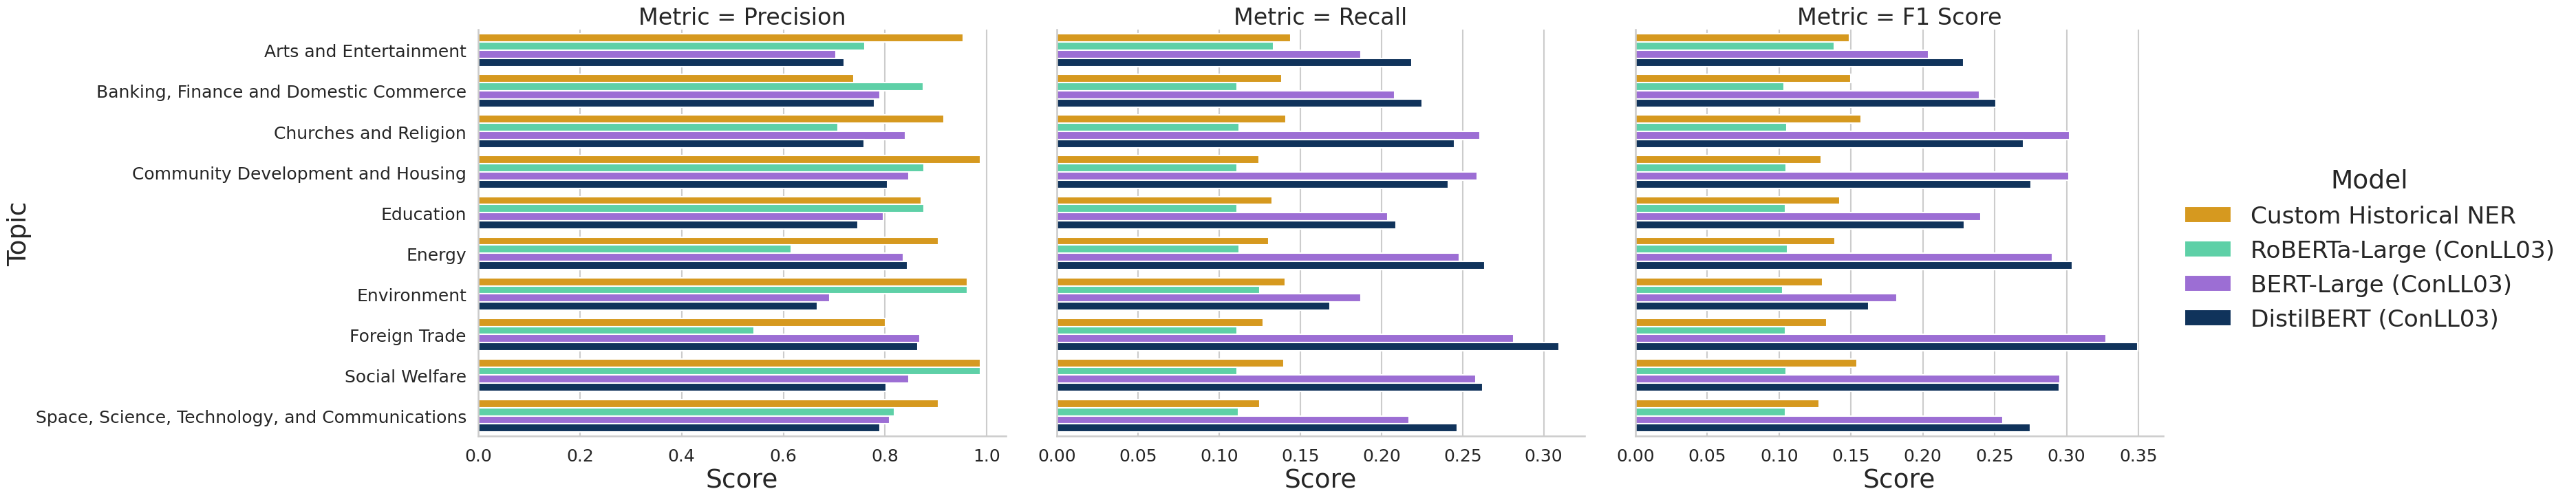

In [10]:
plot_df = df_topic.melt(
    id_vars=["Model", "Topic"],
    var_name="Metric",
    value_name="Score"
)

# Top topics based on high scores
top_topics = (
    plot_df.groupby("Topic")["Score"]
    .max()
    .sort_values(ascending=False)
    .head(10)
    .index
)
# Filter for top topics
plot_df = plot_df[plot_df["Topic"].isin(top_topics)]
plot_df["Topic"] = pd.Categorical(
    plot_df["Topic"],
    categories=sorted(top_topics),
    ordered=True
)


sns.set(style="whitegrid")
sns.set_context("talk", font_scale=1.5)
g = sns.catplot(
    data=plot_df,
    kind="bar",
    x="Score",
    y="Topic",
    hue="Model",
    col="Metric",
    palette=custom_palette,
    height=8,
    aspect=1.5,
    sharex=False,
)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_title(ax.get_title(), fontsize=24)
    ax.xaxis.grid(True)
plt.show()